# School final exams results analysis.

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [2]:
fontsize_reg = 20
fontsize_title = 24
from pylab import rcParams
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['figure.figsize'] = [9.5, 6.5]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 600

plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 24

# Search for pathes to protocols

In [3]:
path_to_protocols = 'протоколы'
list_of_protocols_folders = os.listdir(path_to_protocols)
print(list_of_protocols_folders)

['протоколы_2017', 'протоколы_2018', 'протоколы_2019', 'протоколы_2020', 'протоколы_2021']


In [4]:
# Create a list of pathes to exam protocols
df_protocols = pd.DataFrame()
for folder_year in list_of_protocols_folders:
    folder_now = path_to_protocols + '/' + folder_year
    year_now = folder_year.split('_')[1]
    print()
    print(year_now)
    protocols_now = os.listdir(folder_now)
    for protocol in protocols_now:
        full_path_to_protocol = folder_now + '/' + protocol
        df_protocols = df_protocols.append({
            'year': year_now,
            'subject': protocol.split('.')[0],
            'path': full_path_to_protocol
        }, ignore_index=True)
        print(protocol.split('.')[0], end=', ')


2017
Английский язык, Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, Химия, 
2018
Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, 
2019
Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, Химия, 
2020
Биология, Информатика, История, Литература, Математика, Обществознание, Русский язык, Физика, Химия, 
2021
Английский язык, Биология, Информатика, История, Математика, Обществознание, Русский язык, 

# Define function for reading protocols

In [5]:
def get_or_max_points(string_scores, what_return='get'):
    '''
    Convert string of Part 2 points to resulted point of student
    or to maximum possible points of this exam
    '''
    get_points = 0
    max_points = 0
    for task_point in string_scores.split(")"):
        task_point_splitted = task_point.split('(')
        if len(task_point_splitted) == 2:
            get_points = get_points + int(task_point_splitted[0])
            max_points = max_points + int(task_point_splitted[1])
    if what_return == 'get':
        return get_points
    elif what_return == 'max':
        return max_points
    else:
        print('ERROR')

In [6]:
def file_to_points_df(file_path, year, subject):
    '''
    Read selected file, convert table to conventional DataFrame.
    Convert strings of points to one number.
    '''
    df_pr_now = pd.read_excel(file_path)
    header_col_index = list(df_pr_now.iloc[:, 0]).index('№')
    df_pr_now.columns = df_pr_now.iloc[header_col_index]
    df_pr_now = df_pr_now.drop(index=list(range(0, header_col_index+1)))
    df_pr_now = df_pr_now.reset_index(drop='true')
    # Keep only valid cols
    valid_cols_list = []
    for col_now in df_pr_now.columns:
        if str(col_now) != 'nan':
            valid_cols_list.append(col_now)
    df_pr_now = df_pr_now[valid_cols_list]
    df_pr_now = df_pr_now[df_pr_now[valid_cols_list[6]].notna()]
    df_pr_now['Год'] = str(year)
    if subject == 'Английский язык':
        df_pr_now['Первичный балл'] = df_pr_now['Тестовый балл']
        df_pr_now['Вторичный балл'] = df_pr_now['Первичный балл']
        df_pr_now['Вторая часть'] = df_pr_now['Часть с развёрнутым ответом'].apply(
            lambda x: get_or_max_points(x, what_return='get')
        )
        df_pr_now['Первая часть'] = df_pr_now['Первичный балл'] - df_pr_now['Вторая часть']
    else: 
        
        df_pr_now['Вторичный балл'] = df_pr_now['Балл']
        # Sometimes there is no part 2 in exam
        if str(df_pr_now['Задания с развёрнутым ответом'][0]) == 'nan':
            df_pr_now['Вторая часть'] = 0
        else:
            df_pr_now['Вторая часть'] = df_pr_now['Задания с развёрнутым ответом'].apply(
                lambda x: get_or_max_points(x, what_return='get'))
        df_pr_now['Первая часть'] = df_pr_now['Первичный балл'] - df_pr_now['Вторая часть']
    
    # Redefine chosen cols if you want
    chosen_cols = ['Год', '№', 'Фамилия', 'Первичный балл', 'Вторичный балл', 'Первая часть', 'Вторая часть']
    df_pr_now = df_pr_now[chosen_cols]
    return df_pr_now

# Read protocols and create df of students

In [7]:
# Read every file and convert it to DataFrame, merge all protocols.
df_students = pd.DataFrame()
for i in range(len(df_protocols)):
    file_path_now = df_protocols['path'][i]
    year_now = df_protocols['year'][i]
    subject_now = df_protocols['subject'][i]
    print(subject_now, year_now, end=';  ')
    df_pr_now = file_to_points_df(file_path=file_path_now, year=year_now, subject=subject_now)
    df_pr_now['Предмет'] = subject_now
    df_students = df_students.append(df_pr_now, ignore_index=True)

df_students['_0_50'] = df_students['Вторичный балл'].apply(lambda x: 1 if (x < 50) else 0)
df_students['_80_100'] = df_students['Вторичный балл'].apply(lambda x: 1 if (x >= 80) else 0)
df_students['_50_80'] = (df_students['_0_50'] + df_students['_80_100']).apply(lambda x: 1 if (x == 0) else 0)

for i in ['Первичный балл', 'Вторичный балл', 'Первая часть', 'Вторая часть', '_0_50', '_80_100', '_50_80']:
    df_students[i] = df_students[i].astype(float)

Английский язык 2017;  Биология 2017;  Информатика 2017;  История 2017;  Математика 2017;  Обществознание 2017;  Русский язык 2017;  Физика 2017;  Химия 2017;  Биология 2018;  Информатика 2018;  История 2018;  Математика 2018;  Обществознание 2018;  Русский язык 2018;  Физика 2018;  Биология 2019;  Информатика 2019;  История 2019;  Математика 2019;  Обществознание 2019;  Русский язык 2019;  Физика 2019;  Химия 2019;  Биология 2020;  Информатика 2020;  История 2020;  Литература 2020;  Математика 2020;  Обществознание 2020;  Русский язык 2020;  Физика 2020;  Химия 2020;  Английский язык 2021;  Биология 2021;  Информатика 2021;  История 2021;  Математика 2021;  Обществознание 2021;  Русский язык 2021;  

In [8]:
df_subjects = df_students.groupby(['Предмет', 'Год'], as_index=False).agg(
    Учащихся = ('№', 'count'),
    Первая_часть_средний = ('Первая часть', 'mean'),
    Вторая_часть_средний = ('Вторая часть', 'mean'),
    Средний = ('Вторичный балл', 'mean'),
    Макс = ('Вторичный балл', 'max'),
    _0_50 = ('_0_50', 'sum'),
    _50_80 = ('_50_80', 'sum'),
    _80_100 = ('_80_100', 'sum'),
)
for i in ['Первая_часть_средний', 'Вторая_часть_средний', 'Средний', 'Макс']:
    df_subjects[i] = df_subjects[i].apply(lambda x: round(x, 1))

df_subjects.sample(5)

,Предмет,Год,Учащихся,Первая_часть_средний,Вторая_часть_средний,Средний,Макс,_0_50,_50_80,_80_100
17,Литература,2020,1,12.0,31.0,65.0,65.0,0.0,1.0,0.0
30,Русский язык,2019,19,18.8,16.8,61.2,87.0,4.0,13.0,2.0
16,История,2021,2,10.5,2.5,37.0,42.0,2.0,0.0,0.0
3,Биология,2018,5,18.4,1.8,42.0,46.0,5.0,0.0,0.0
23,Обществознание,2017,11,21.9,9.2,55.5,84.0,3.0,7.0,1.0


# Charts

In [10]:
fontsize_reg = 20
fontsize_title = 24
from pylab import rcParams
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['figure.figsize'] = [9.5, 6.5]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 600

plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 24

In [11]:
blue_color = '#9DC3E6'
grey_color = '#BFBFBF'
orange_color = '#F4B183'
almost_black_color = '#404040'

# Plot the number of student participated in each exam for each year.

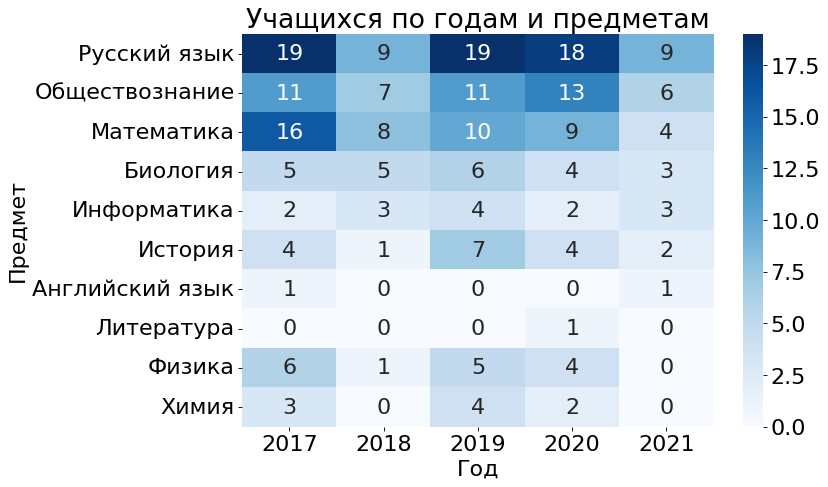

In [12]:
import seaborn as sns
to_plot = df_subjects.groupby(['Предмет', 'Год'], as_index=False)['Учащихся'].agg('sum').pivot(
    index='Предмет', columns='Год', values='Учащихся', 
).fillna(0).sort_values('2021', ascending=False)
sns.heatmap(
    to_plot, cmap='Blues', annot=True, xticklabels=to_plot.columns
)
plt.title('Учащихся по годам и предметам')
plt.savefig('plots/' + 'heatmap_subjects'  + '.png', bbox_inches = "tight", dpi=600)

# Bar plots of mean and max points

In [13]:
def plot_mean_max_dynamics(df_subjects, subject_now, show_plot=True, save_plot=True):
    '''
    Plot the changes in mean and max points of selected exam over years
    '''
    subject_now = subject_now
    data_to_plot = df_subjects[df_subjects['Предмет'] == subject_now].sort_values(by='Год', ascending=False)
    fig, ax = plt.subplots()
    plt.title(subject_now + '\n' + 'Динамика среднего и максимального баллов', loc='left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ind = np.arange(len(data_to_plot))
    height = 0.4

    
    secondary_bars = ax.barh(
        width=data_to_plot['Макс'], label='Макс', 
        height=height, color=grey_color, y=ind + height/2)
    
    primary_bars = ax.barh(
        width=data_to_plot['Средний'], label='Средний', 
        height=height, color=blue_color, y=ind - height/2)

    plt.yticks(ticks=list(range(len(data_to_plot['Год']))), labels=data_to_plot['Год'], rotation=0)
    plt.legend(bbox_to_anchor=(0.25, -0.15), loc='center', ncol=2)
#     ax.text(x=data_to_plot['Макс'].max(), y=-0.5, s=subject_now, fontsize=12, c='#999999',
#             horizontalalignment='right', verticalalignment='bottom')

    for i, v in enumerate(data_to_plot['Средний']):
        if str(v)[-2:] == '.0':
            value_to_show = int(round(v, 0))
        else:
            value_to_show = round(v, 1)
        ax.text(v + 0.1, i - height/2, str(value_to_show), fontsize=16,
               horizontalalignment='left', verticalalignment='center')

    for i, v in enumerate(data_to_plot['Макс']):
        if str(v)[-2:] == '.0':
            value_to_show = int(round(v, 0))
        else:
            value_to_show = round(v, 1)
        ax.text(v + 0.1, i + height/2, str(value_to_show), fontsize=16,
               horizontalalignment='left', verticalalignment='center')
    
    plt.tight_layout()
    if save_plot:
        plt.savefig('plots/' + subject_now + ' динамика ср и макс'  + '.png', bbox_inches = "tight", dpi=600)
        
    if show_plot:
        plt.show()
    else:
        plt.close()

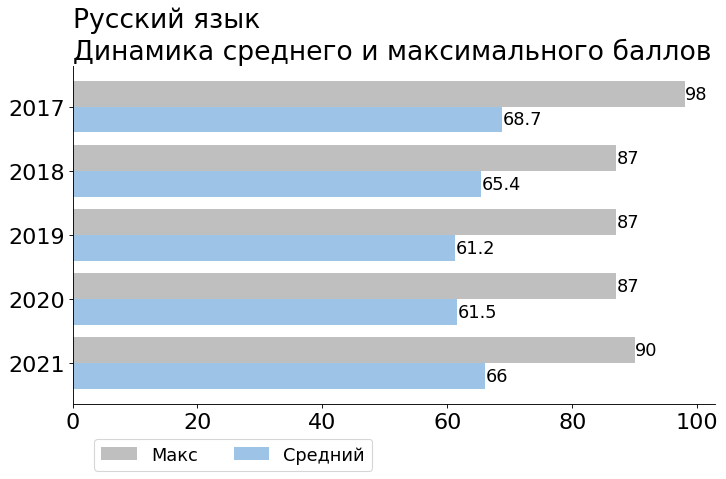

In [14]:
plot_mean_max_dynamics(df_subjects, subject_now='Русский язык', show_plot=True, save_plot=False)

In [15]:
subjects_last_year = list(df_subjects[df_subjects['Год'].astype(str) == str(df_subjects['Год'].max())]['Предмет'].unique())
print(subjects_last_year)

for subject_now in subjects_last_year:
    plot_mean_max_dynamics(df_subjects, subject_now=subject_now, show_plot=False, save_plot=True)

['Английский язык', 'Биология', 'Информатика', 'История', 'Математика', 'Обществознание', 'Русский язык']


# Stacked bar of points per first and second exam parts

In [16]:
def points_part_1_2_plot(df_subjects, subject_now, show_plot=True, save_plot=True):
    '''
    Plots the mean point of Part 1 and Part of selected exam over years
    '''
    subject_now = subject_now
    data_to_plot = df_subjects[df_subjects['Предмет'] == subject_now].sort_values(by='Год', ascending=True)

    ax = data_to_plot[['Первая_часть_средний', 'Вторая_часть_средний']].plot(
        stacked=True, kind='bar', rot='horizontal', 
        color=[grey_color, blue_color], width=0.8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.title(subject_now + '\n' + 'Распределение первичных баллов между частями', loc='left')

    plt.xticks(ticks=list(range(len(data_to_plot['Год']))), labels=data_to_plot['Год'], rotation=0)
    # .patches is everything inside of the chart
    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The height of the bar is the data value and can be used as the label
        label_text = f'{height}'  # f'{height:.2f}' to format decimal values

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y, round(float(label_text), 1), ha='center', va='center')

    plt.legend(bbox_to_anchor=(0, -0.25), loc='lower left', ncol=2)
    ax.set_ylabel("Первичный балл")
    
    ax.set_axisbelow(True)
    plt.grid(axis='y')
    
    plt.tight_layout()
    if save_plot:
        plt.savefig('plots/'+ subject_now + ' распред части'  + '.png', bbox_inches = "tight", dpi=600)
        
    if show_plot:
        plt.show()
    else:
        plt.close()

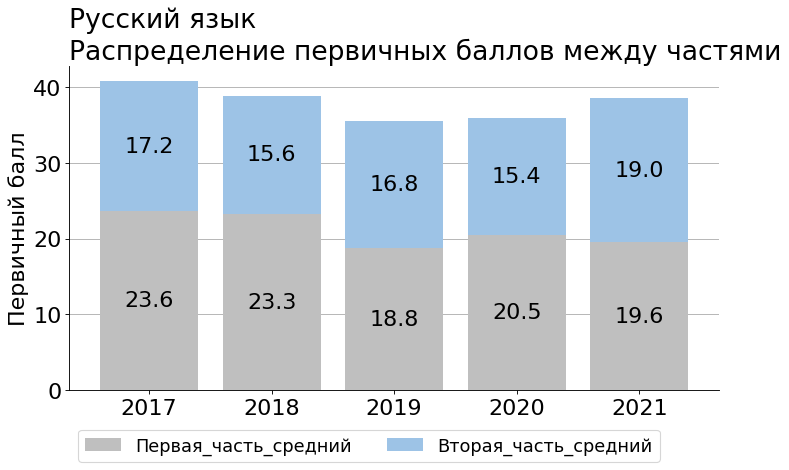

In [17]:
points_part_1_2_plot(df_subjects, subject_now='Русский язык', show_plot=True, save_plot=False)

In [18]:
subjects_last_year = list(df_subjects[df_subjects['Год'].astype(str) == str(df_subjects['Год'].max())]['Предмет'].unique())
print(subjects_last_year)

for subject_now in subjects_last_year:
    points_part_1_2_plot(df_subjects, subject_now=subject_now, show_plot=False, save_plot=True)

['Английский язык', 'Биология', 'Информатика', 'История', 'Математика', 'Обществознание', 'Русский язык']


# Histograms of points for chosen year

In [19]:
def hist_one_subject_year(df_students, subject_now, year_now, show_plot=True, save_plot=True):
    '''
    Plot the histogram of point for selected subject of one year
    '''
    subject_now = subject_now
    year_now = year_now
    data_to_plot = df_students[
        (df_students['Предмет'] == subject_now)
        & (df_students['Год'].astype(str) == str(year_now))
    ].sort_values(by='Год', ascending=True)

    bins=list(range(0, 101, 10))

    ax = data_to_plot['Вторичный балл'].plot(kind='hist', bins=bins, edgecolor='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, 100)
    # plt.grid(axis='x')
    plt.xticks(ticks=bins, labels=bins, rotation=0)

    plt.title(subject_now + ', ' + str(year_now) + '\n' + 'Гистограмма учащихся по баллу ЕГЭ', loc='left')
    plt.xlabel('Вторичный балл')
    plt.ylabel('Учащихся')

    for i in range(0, 5):
        ax.patches[i].set_color(orange_color)
        ax.patches[i].set_edgecolor('white')
    for i in range(5, 8):
        ax.patches[i].set_color(grey_color)
        ax.patches[i].set_edgecolor('white')
    for i in range(8, 10):
        ax.patches[i].set_color(blue_color)
        ax.patches[i].set_edgecolor('white')
        
    plt.tight_layout()
    if save_plot:
        plt.savefig('plots/'+ subject_now + ' Гистограмма одна'  + '.png', bbox_inches = "tight", dpi=600)
        
    if show_plot:
        plt.show()
    else:
        plt.close()

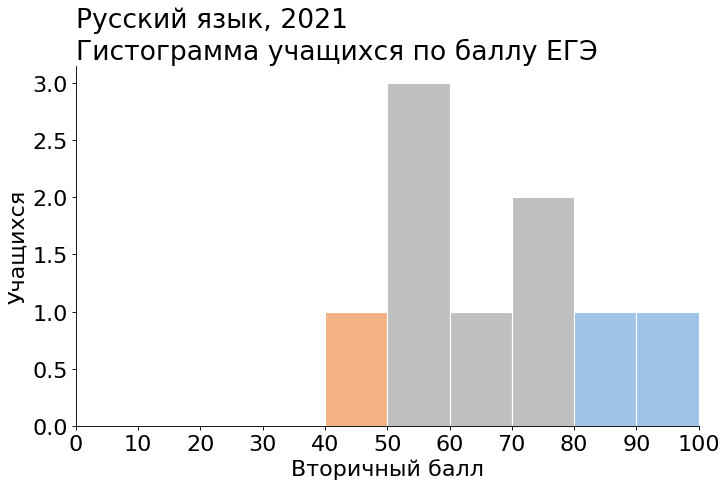

In [20]:
hist_one_subject_year(df_students, subject_now='Русский язык', year_now='2021', show_plot=True, save_plot=False)

In [21]:
subjects_last_year = list(df_subjects[df_subjects['Год'].astype(str) == str(df_subjects['Год'].max())]['Предмет'].unique())
print(subjects_last_year)

for subject_now in subjects_last_year:
    hist_one_subject_year(df_students, subject_now, year_now, show_plot=False, save_plot=True)

['Английский язык', 'Биология', 'Информатика', 'История', 'Математика', 'Обществознание', 'Русский язык']


# Distribution of points several years (-50, 50-80, 80+)

In [22]:
def plot_mean_max_dynamics(df_subjects, subject_now, show_plot=True, save_plot=True):
    '''
    Plot handcrafted histograms of points for one subject over years
    '''
    subject_now = subject_now
    data_to_plot = df_subjects[df_subjects['Предмет'] == subject_now].sort_values(by='Год', ascending=True)
    fig, ax = plt.subplots()
    plt.title(subject_now + '\n' + 'Распределение учащихся по баллам ЕГЭ', loc='left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ind = np.arange(len(data_to_plot))
    width = 0.25
    minus_const = 0.025

    _0_50 = ax.bar(label='0_50', height=data_to_plot['_0_50'], width=width-minus_const, x=ind - width, color=orange_color)
    _50_80 = ax.bar(label='50_80', height=data_to_plot['_50_80'], width=width-minus_const, x=ind, color=grey_color)
    _80_100 = ax.bar(label='80_100', height=data_to_plot['_80_100'], width=width-minus_const, x=ind + width, color=blue_color)

    plt.xticks(ticks=list(range(len(data_to_plot['Год']))), labels=data_to_plot['Год'], rotation=0)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='center', ncol=3)

    for i, v in enumerate(data_to_plot['_0_50']):
        if str(v)[-2:] == '.0':
            value_to_show = int(round(v, 0))
        else:
            value_to_show = round(v, 1)
        ax.text(i - width, v, str(value_to_show), fontsize=16,
               horizontalalignment='center', verticalalignment='bottom')

    for i, v in enumerate(data_to_plot['_50_80']):
        if str(v)[-2:] == '.0':
            value_to_show = int(round(v, 0))
        else:
            value_to_show = round(v, 1)
        ax.text(i, v, str(value_to_show), fontsize=16,
               horizontalalignment='center', verticalalignment='bottom')
        
    for i, v in enumerate(data_to_plot['_80_100']):
        if str(v)[-2:] == '.0':
            value_to_show = int(round(v, 0))
        else:
            value_to_show = round(v, 1)
        ax.text(i + width, v, str(value_to_show), fontsize=16,
               horizontalalignment='center', verticalalignment='bottom')
    
    plt.tight_layout()
    if save_plot:
        plt.savefig('plots/' + subject_now + ' распред баллов по годам'  + '.png', bbox_inches = "tight", dpi=600)
        
    if show_plot:
        plt.show()
    else:
        plt.close()

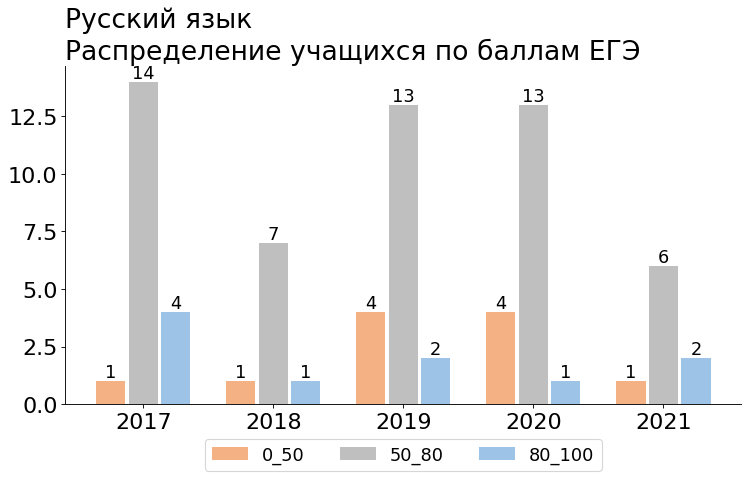

In [23]:
plot_mean_max_dynamics(df_subjects, subject_now='Русский язык', show_plot=True, save_plot=False)

In [24]:
subjects_last_year = list(df_subjects[df_subjects['Год'].astype(str) == str(df_subjects['Год'].max())]['Предмет'].unique())
print(subjects_last_year)

for subject_now in subjects_last_year:
    plot_mean_max_dynamics(df_subjects, subject_now=subject_now, show_plot=False, save_plot=True)

['Английский язык', 'Биология', 'Информатика', 'История', 'Математика', 'Обществознание', 'Русский язык']


# Comparing school points with mean russia results

In [25]:
russia_means = [
    ["Математика", 55.1], 
    ["Русский язык", 71.4], 
    ["Физика", 55.1], 
    ["Обществознание", 56.4], 
    ["Литература", 66.0], 
    ["Химия", 53.8], 
    ["Информатика", 62.8], 
    ["Биология", 51.1], 
    ["История", 54.9], 
    ["Английский язык", 72.2],
]

In [26]:
df_compare_russia = df_subjects[['Предмет', 'Год', 'Средний', 'Макс']]
df_compare_russia['Чей'] = ' Школа - ' + df_compare_russia['Год']

for subject_now_mean in russia_means:
    df_compare_russia = df_compare_russia.append({
        'Предмет': subject_now_mean[0],
        'Год': '2021',
        'Средний': subject_now_mean[1],
        'Чей': 'Россия 2021'
    }, ignore_index=True)

df_compare_russia.sort_values(by='Чей').tail(2)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Предмет,Год,Средний,Макс,Чей
47,Биология,2021,51.1,NaN,Россия 2021
49,Английский язык,2021,72.2,NaN,Россия 2021


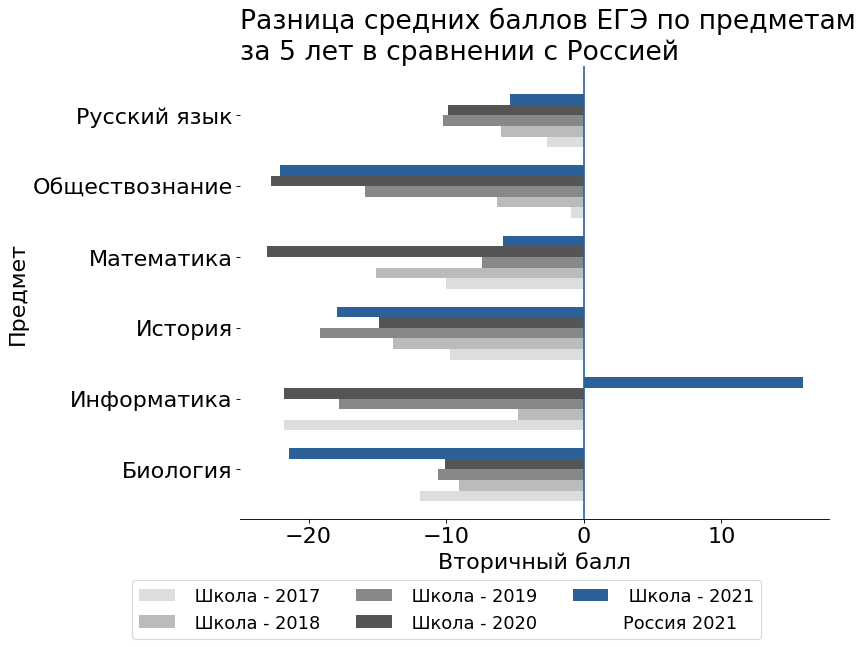

In [27]:
to_plot = df_compare_russia.pivot(index='Предмет', columns='Чей', values='Средний').dropna()
for col_now in to_plot.columns:
    to_plot[col_now] = to_plot[col_now] - to_plot['Россия 2021']
ax = to_plot.plot(
    kind='barh', color=['#DDDDDD', '#BBBBBB', '#888888', '#555555', '#2B6198', '#FFFFFF'],
    width=0.9,
    figsize=(9.5, 7.5)
)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axvline(x=0, color = '#2B6198')
plt.title('Разница средних баллов ЕГЭ по предметам' + '\n' + 'за 5 лет в сравнении с Россией', loc='left')
plt.xlabel('Вторичный балл')
plt.legend(bbox_to_anchor=(0.35, -0.20), loc='center', ncol=3)
plt.savefig('plots/' + 'Разница средних баллов ЕГЭ по предметам'  + '.png', bbox_inches = "tight", dpi=600)

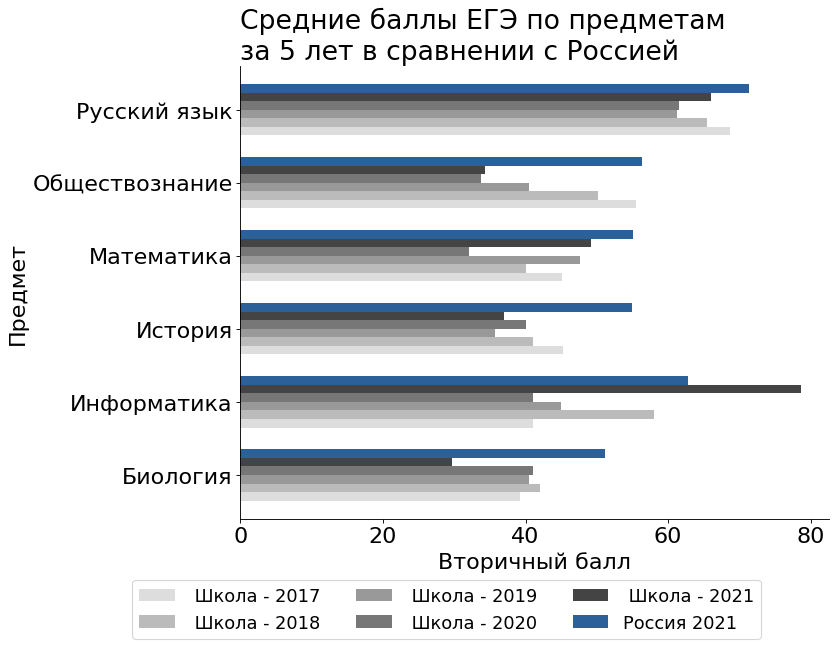

In [28]:
to_plot = df_compare_russia.pivot(index='Предмет', columns='Чей', values='Средний').dropna()
# for col_now in to_plot.columns:
#     to_plot[col_now] = to_plot[col_now] - to_plot['Россия 2021']
ax = to_plot.plot(
    kind='barh', color=['#DDDDDD', '#BBBBBB', '#999999', '#777777', '#444444', '#2B6198'],
    width=0.7,
    figsize=(9.5, 7.5)
)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Средние баллы ЕГЭ по предметам' + '\n' + 'за 5 лет в сравнении с Россией', loc='left')
plt.xlabel('Вторичный балл')
plt.legend(bbox_to_anchor=(0.35, -0.20), loc='center', ncol=3)
plt.savefig('plots/' + subject_now + 'Средние баллы ЕГЭ по предметам'  + '.png', bbox_inches = "tight", dpi=600)

# Correlation analysis between pair of subjects

In [29]:
df_students['id'] = df_students['Фамилия'] + df_students['Год']
df_students_pivot = df_students.pivot(index='id', columns='Предмет', values='Вторичный балл')
df_students_pivot

Предмет,Английский язык,Биология,Информатика,История,Литература,Математика,Обществознание,Русский язык,Физика,Химия
id,,,,,,,,,,
-12155433958754988512021,NaN,NaN,88.0,NaN,NaN,70.0,NaN,90.0,NaN,NaN
-12429222305378300422020,NaN,NaN,NaN,NaN,NaN,23.0,29.0,46.0,38.0,NaN
-14102946254602340872017,NaN,NaN,40.0,NaN,NaN,45.0,51.0,73.0,NaN,NaN
-15909137142578637402019,NaN,NaN,NaN,40.0,NaN,45.0,42.0,51.0,NaN,NaN
-17046843859985106472019,NaN,NaN,20.0,15.0,NaN,NaN,31.0,46.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
87003094494928786272020,NaN,NaN,NaN,NaN,65.0,NaN,53.0,87.0,NaN,NaN
87665334579039230702019,NaN,43.0,NaN,36.0,NaN,39.0,39.0,69.0,45.0,42.0
89052556883251732662020,NaN,NaN,NaN,NaN,NaN,27.0,18.0,50.0,23.0,NaN


In [30]:
top_corr = df_students_pivot.corr().unstack().sort_values(kind="quicksort", ascending=False).dropna()
top_corr = top_corr[top_corr != 1.0].drop_duplicates()
top_corr

Предмет         Предмет       
Информатика     Обществознание    0.932669
Физика          Обществознание    0.866222
Математика      Информатика       0.840323
Информатика     Русский язык      0.776347
Математика      Биология          0.771492
История         Обществознание    0.689852
Обществознание  Русский язык      0.678005
                Математика        0.675615
Математика      Русский язык      0.661974
Физика          Математика        0.659303
                История           0.645823
Биология        История           0.600347
Химия           Русский язык      0.584738
Русский язык    Физика            0.566747
Биология        Химия             0.532148
Русский язык    Биология          0.515222
История         Математика        0.511647
Русский язык    История           0.479995
Биология        Обществознание    0.340572
Химия           Математика        0.169572
Обществознание  Химия            -1.000000
dtype: float64

Text(0, 0, '0.6756')

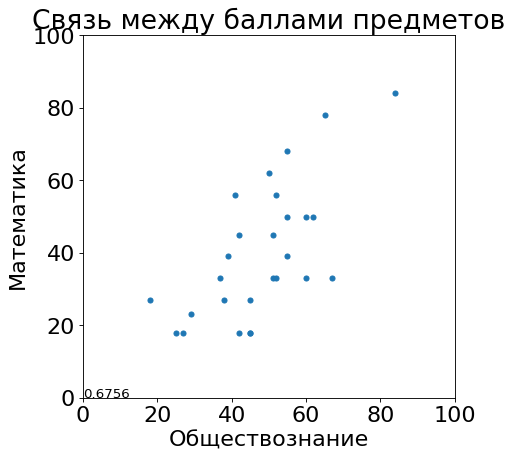

In [31]:
x='Обществознание'
y='Математика'
df_students_pivot.plot(
    kind='scatter', x=x, y=y, figsize=(6,6),
    xlim=(0,100), ylim=(0,100)
)
plt.title('Связь между баллами предметов')
plt.text(x=0, y=0, s=str(round(top_corr[7], 4)), fontsize=12)

In [32]:
for i in range(0, len(top_corr)):
    x=top_corr.index[i][0]
    y=top_corr.index[i][1]
    df_students_pivot.plot(
        kind='scatter', x=x, y=y, figsize=(6,6),
        xlim=(0,100), ylim=(0,100)
    )
    plt.title('Связь между баллами предметов')
    plt.text(x=0, y=0, s=str(round(top_corr[i], 4)), fontsize=12)
    plt.savefig('plots/corrs/' + 'scatter_subjects_' + x + '_' + y + '.png', bbox_inches = "tight", dpi=600)
    plt.close()

# Delete private data of students from xlsx

Use these code to remove all private data of students with hash

The hash may be used as individual ID for each student

In [40]:
df_protocols = pd.DataFrame()
for folder_year in list_of_protocols_folders:
    folder_now = path_to_protocols + '/' + folder_year
    year_now = folder_year.split('_')[1]
    print()
    print(year_now)
    protocols_now = os.listdir(folder_now)
    for protocol in protocols_now:
        full_path_to_protocol = folder_now + '/' + protocol
        df_protocols = df_protocols.append({
            'year': year_now,
            'subject': protocol.split('.')[0],
            'path': full_path_to_protocol
        }, ignore_index=True)
        print(protocol.split('.')[0], end=', ')


2017
Английский язык, Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, Химия, 
2018
Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, 
2019
Биология, Информатика, История, Математика, Обществознание, Русский язык, Физика, Химия, 
2020
Биология, Информатика, История, Литература, Математика, Обществознание, Русский язык, Физика, Химия, 
2021
Английский язык, Биология, Информатика, История, Математика, Обществознание, Русский язык, 

In [41]:
n_students_per_subject = df_subjects.groupby(['Предмет', 'Год'], as_index=False)['Учащихся'].agg('sum').pivot(
    index='Предмет', columns='Год', values='Учащихся', 
).fillna(0).sort_values('2021', ascending=False)
n_students_per_subject

Год,2017,2018,2019,2020,2021
Предмет,,,,,
Русский язык,19.0,9.0,19.0,18.0,9.0
Обществознание,11.0,7.0,11.0,13.0,6.0
Математика,16.0,8.0,10.0,9.0,4.0
Биология,5.0,5.0,6.0,4.0,3.0
Информатика,2.0,3.0,4.0,2.0,3.0
История,4.0,1.0,7.0,4.0,2.0
Английский язык,1.0,0.0,0.0,0.0,1.0
Литература,0.0,0.0,0.0,1.0,0.0
Физика,6.0,1.0,5.0,4.0,0.0


In [45]:
from openpyxl import load_workbook

for i_now in range(len(df_protocols)):
    file_path = df_protocols.loc[i_now, 'path']
    
    year_now = df_protocols.loc[i_now, 'year']
    subject_now = df_protocols.loc[i_now, 'subject']
    students_num_now = int(n_students_per_subject[str(year_now)][str(subject_now)])
    
    print()
    print(year_now, subject_now, students_num_now, end=', ')

    columns_to_hash = ['M', 'N', 'O', 'Q', 'S']
    columns_to_delete = ['C', 'E', 'G', 'I', 'K']
    columns_to_hash_eng = ['F', 'H', 'I', 'J']
    columns_to_delete_eng = ['B', 'C', 'D']

    wb = load_workbook(file_path)
    ws = wb.active  # or wb.active

    ws['A2'].value = 'Регион'
    ws['A4'].value = 'Школа'
    
    current_pos_of_number_symbol = 0
    for i in range(5, 15):
        if ws['A' + str(i)].value == '№':
            current_pos_of_number_symbol = i

    print(ws['A' + str(current_pos_of_number_symbol)].value, end=', ')
    if ws['A' + str(current_pos_of_number_symbol)].value == '№':

        if subject_now != 'Английский язык':
            print('not_eng', end=', ')
            for student_now in range(1, students_num_now+1):
                row_num_now = current_pos_of_number_symbol + student_now
                print(row_num_now, end=', ')
                # calculate hash of student private data
                private_row = '_'
                for column_now in columns_to_hash:
                    try:
                        private_row = private_row + ws[column_now + str(row_num_now)].value
                    except:
                        print('empty cell:', column_now + str(row_num_now), end=', ')
                calculated_hash = str(hash(private_row))
                # delete all private values
                for column_now in columns_to_delete + columns_to_hash:
                    ws[column_now + str(row_num_now)].value = 'deleted_data'
                # insert hash as id instead of student private data
                for column_now in columns_to_hash:
                    ws[column_now + str(row_num_now)].value = calculated_hash

        else: # if 'Английский язык':
            print('eng', end=', ')
            for student_now in range(1, students_num_now+1):
                row_num_now = current_pos_of_number_symbol + student_now
                print(row_num_now, end=', ')
                # calculate hash of student private data
                private_row = '_'
                for column_now in columns_to_hash_eng:
                    try:
                        private_row = private_row + ws[column_now + str(row_num_now)].value
                    except:
                        print('empty cell:', column_now + str(row_num_now), end=', ')
                calculated_hash = str(hash(private_row.replace(' ', '')))
                # delete all private values
                for column_now in columns_to_delete_eng + columns_to_hash_eng:
                    ws[column_now + str(row_num_now)].value = 'deleted_data'
                # insert hash as id instead of student private data
                for column_now in columns_to_hash_eng:
                    ws[column_now + str(row_num_now)].value = calculated_hash

    else: 
        print('ERROR - The symbol № has an unappropriated position')

    wb.save(file_path)


2017 Английский язык 1, №, eng, 8, 
2017 Биология 5, №, not_eng, 8, 9, 10, 11, 12, 
2017 Информатика 2, №, not_eng, 8, 9, 
2017 История 4, №, not_eng, 8, empty cell: O8, 9, 10, 11, 
2017 Математика 16, №, not_eng, 8, 9, empty cell: O9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
2017 Обществознание 11, №, not_eng, 8, empty cell: O8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
2017 Русский язык 19, №, not_eng, 8, 9, empty cell: O9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
2017 Физика 6, №, not_eng, 8, 9, 10, empty cell: O10, 11, 12, 13, 
2017 Химия 3, №, not_eng, 8, 9, 10, 
2018 Биология 5, №, not_eng, 8, 9, 10, 11, 12, 
2018 Информатика 3, №, not_eng, 8, 9, 10, 
2018 История 1, №, not_eng, 8, 
2018 Математика 8, №, not_eng, 8, 9, 10, 11, 12, 13, 14, 15, 
2018 Обществознание 7, №, not_eng, 8, 9, 10, 11, 12, 13, 14, 
2018 Русский язык 9, №, not_eng, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
2018 Физика 1, №, not_eng, 8, 
2019 Биология 6, №, not_eng, 9, 10, 